# Linear Classifiers in Python - Part 4
- Support Vector Machine (SVM)
    - SVM has linear and nonlinear kernels (kernel hyperparameter)
    - SVM nonlinear kernels make feature transformations to make nonlinear boundary
    - C hyperparameter controls regularization
    - gamma hyperparameter controls smoothness of boundary (inverse RBF smoothness)
- Stochastic Gradient Descent (SGDClassifier)
    - logistic_regression = SGDClassifier(loss='log')
    - linear_svm = SGDClassifier(loss='hinge')
    - alpha hyperparameter = 1/C

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

SEED = 1

In [6]:
def plot_classifier(X, y, clf, ax=None, ticks=False, proba=False, lims=None): # assumes classifier "clf" is already fit
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1, lims=lims)

    if ax is None:
        plt.figure()
        ax = plt.gca()
        show = True
    else:
        show = False

    # can abstract some of this into a higher-level function for learners to call
    cs = plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8, proba=proba)
    if proba:
        cbar = plt.colorbar(cs)
        cbar.ax.set_ylabel('probability of red $\Delta$ class', fontsize=20, rotation=270, labelpad=30)
        cbar.ax.tick_params(labelsize=14)
    #ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=30, edgecolors='k', linewidth=1)
    labels = np.unique(y)
    if len(labels) == 2:
        ax.scatter(X0[y==labels[0]], X1[y==labels[0]], cmap=plt.cm.coolwarm, s=60, c='b', marker='o', edgecolors='k')
        ax.scatter(X0[y==labels[1]], X1[y==labels[1]], cmap=plt.cm.coolwarm, s=60, c='r', marker='^', edgecolors='k')
    else:
        ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=50, edgecolors='k', linewidth=1)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
#     ax.set_xlabel(data.feature_names[0])
#     ax.set_ylabel(data.feature_names[1])
    if ticks:
        ax.set_xticks(())
        ax.set_yticks(())
#     ax.set_title(title)
    if show:
        plt.show()
    else:
        return ax
    
def make_meshgrid(x, y, h=.02, lims=None):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """

    if lims is None:
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
    else:
        x_min, x_max, y_min, y_max = lims
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, proba=False, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    if proba:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,-1]
        Z = Z.reshape(xx.shape)
        out = ax.imshow(Z,extent=(np.min(xx), np.max(xx), np.min(yy), np.max(yy)), origin='lower', vmin=0, vmax=1, **params)
        ax.contour(xx, yy, Z, levels=[0.5])
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, **params)
    return out

## Datasets

### Wine

In [2]:
wine = datasets.load_wine()

### Digits

In [18]:
digits = datasets.load_digits()

## Support Vector Machines
In this chapter you will learn all about the details of support vector machines. You'll learn about tuning hyperparameters for these models and using kernels to fit non-linear decision boundaries.

### Effect of removing examples
Support vectors are defined as training examples that influence the decision boundary. In this exercise, you'll observe this behavior by removing non support vectors from the training set.

The wine quality dataset is already loaded into X and y (first two features only). (Note: we specify lims in plot_classifier() so that the two plots are forced to use the same axis limits and can be compared directly.)

In [9]:
X, y = wine.data[:, :2], wine.target

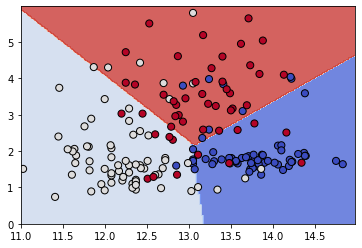

In [11]:
# Train a linear SVM
svm = SVC(kernel="linear")
svm.fit(X, y)
plot_classifier(X, y, svm, lims=(11,15,0,6))

In [12]:
# Make a new data set keeping only the support vectors
print("Number of original examples", len(X))
print("Number of support vectors", len(svm.support_))
X_small = X[svm.support_]
y_small = y[svm.support_]

Number of original examples 178
Number of support vectors 81


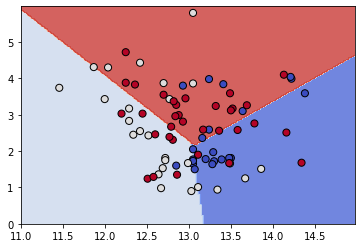

In [13]:
# Train a new SVM using only the support vectors
svm_small = SVC(kernel="linear")
svm_small.fit(X_small, y_small)
plot_classifier(X_small, y_small, svm_small, lims=(11,15,0,6))

### GridSearchCV warm-up
In the video we saw that increasing the RBF kernel hyperparameter gamma increases training accuracy. In this exercise we'll search for the gamma that maximizes cross-validation accuracy using scikit-learn's GridSearchCV. A binary version of the handwritten digits dataset, in which you're just trying to predict whether or not an image is a "2", is already loaded into the variables X and y.

In [23]:
X, y = digits.data, digits.target == 2

In [26]:
# Instantiate an RBF SVM
svm = SVC()

In [27]:
# Instantiate the GridSearchCV object and run the search
parameters = {'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1]}
searcher = GridSearchCV(svm, parameters)
searcher.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [28]:
# Report the best parameters
print("Best CV params", searcher.best_params_)

Best CV params {'gamma': 0.001}


### Jointly tuning gamma and C with GridSearchCV
In the previous exercise the best value of gamma was 0.001 using the default value of C, which is 1. In this exercise you'll search for the best combination of C and gamma using GridSearchCV.

As in the previous exercise, the 2-vs-not-2 digits dataset is already loaded, but this time it's split into the variables X_train, y_train, X_test, and y_test. Even though cross-validation already splits the training set into parts, it's often a good idea to hold out a separate test set to make sure the cross-validation results are sensible.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target == 2, 
                                                    random_state=SEED)

In [31]:
# Instantiate an RBF SVM
svm = SVC()

In [32]:
# Instantiate the GridSearchCV object and run the search
parameters = {'C':[0.1, 1, 10], 'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1]}
searcher = GridSearchCV(svm, parameters)
searcher.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10],
                         'gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [33]:
# Report the best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)

Best CV params {'C': 1, 'gamma': 0.001}
Best CV accuracy 1.0


In [34]:
# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))

Test accuracy of best grid search hypers: 0.9977777777777778


### Using SGDClassifier
In this final coding exercise, you'll do a hyperparameter search over the regularization type, regularization strength, and the loss (logistic regression vs. linear SVM) using SGDClassifier().

In [35]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target == 2, 
                                                    random_state=SEED)

In [38]:
# We set random_state=0 for reproducibility 
linear_classifier = SGDClassifier(random_state=0)

In [39]:
# Instantiate the GridSearchCV object and run the search
parameters = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
             'loss':['hinge', 'log'], 'penalty':['l1', 'l2']}
searcher = GridSearchCV(linear_classifier, parameters, cv=10)
searcher.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=0,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'loss': ['hinge', 'log'], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train

In [40]:
# Report the best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))

Best CV params {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}
Best CV accuracy 0.9977777777777778
Test accuracy of best grid search hypers: 0.9977777777777778
